In [1]:
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import json
import pprint
import tqdm
import time
import numpy as np
from datetime import datetime
from datetime import timedelta
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
import os
# First define the log function to gather the log information
def log(response,logfile,output_path=os.getcwd()):
    # Open or create the csv file
    if os.path.isfile(logfile): #If the log file exists, open it and allow for changes     
        log = open(logfile,'a')
    else: #If the log file does not exist, create it and make headers for the log variables
        log = open(logfile,'w')
        header = ['timestamp','status_code','length','output_file', 'link']
        log.write(';'.join(header) + "\n") #Make the headers and jump to new line
        
    # Gather log information
    status_code = response.status_code #Status code from the request result
    timestamp = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())) #Local time
    length = len(response.text) #Length of the HTML-string
    
    # Open the log file and append the gathered log information
    with open(logfile,'a') as log:
        log.write(f'{timestamp};{status_code};{length};{output_path};{response.url}' + "\n")

logfile = 'log18_08_1.csv'

In [3]:
#Get all LINKS to articles (ekstrabladet
dr_forside_url = 'https://www.dr.dk'


headers = {
    'name': 'Marie Skovbye',
    'email': 'marieskovbye@gmail.com',
    'message': 'Student at KU. Doing a one-week project, Introduction to Social Data Science'
}


def get_links_articles(area):
    url = f'{dr_forside_url}{area}'
    resp = requests.get(url, headers=headers)
    soup = BeautifulSoup(resp.content, "html.parser")
    
# Find all a-tags with a href-attribut and make a liste with the href-attributs 
    atags_usorteret_liste = soup.find_all('a', href=True)
    href_usorteret_liste = [item['href'] for item in atags_usorteret_liste]
    
# Discard all url that do not lead to articles (that are)
    half_way_list = [] 
    topic_of_article = area.split('/')[-1]
    for article_url in href_usorteret_liste:
        if '-' in article_url:
                half_way_list.append(article_url)
        else: 
            pass
    
    href_list = []
    for article_url in half_way_list:
        if article_url.split('/').count('https:') == 0:
            href_list.append(article_url)
        else: 
            pass     
    
    href_list = np.unique(href_list)

    return ['https://www.dr.dk'+ url for url in href_list]

topics_news = ['indland', 'udland', 'penge', 'politik', 'regionalt', 'vejret', 'kultur', 'viden']
dr_urls = {}

for topic in topics_news:
    articles_topic_news = f"/nyheder/{topic}"   
    dr_urls[topic] = get_links_articles(articles_topic_news)
    time.sleep(0.5)

dr_urls['sport'] = get_links_articles('/sporten')


dr_urls

{'indland': ['https://www.dr.dk/nyheder/bo-lidegaard-om-afghanistan-vi-har-ikke-haft-modet-til-se-nederlaget-i-oejnene',
  'https://www.dr.dk/nyheder/indland/10000-lejeboliger-staar-tomme-i-aarhus-udlejerne-boer-presses-paa-huslejen',
  'https://www.dr.dk/nyheder/indland/al-qaeda-opfordrer-til-angreb-mod-danmark-efter-koranafbraendinger',
  'https://www.dr.dk/nyheder/indland/alt-mange-patienter-og-alt-faa-psykiatere-malene-har-faaet-en-tid-om-aar',
  'https://www.dr.dk/nyheder/indland/anton-og-sigrid-moeder-en-time-senere-i-skole-vi-er-blevet-mere-sociale',
  'https://www.dr.dk/nyheder/indland/automekanikerne-skal-paa-arbejde-efter-danskeres-biler-blev-smadret-af-hagl-i',
  'https://www.dr.dk/nyheder/indland/danskere-spiser-cirka-52-kilo-koed-om-aaret-hvorfor-elsker-vi-koed-saa-meget',
  'https://www.dr.dk/nyheder/indland/efterspoergsel-paa-droner-til-ukraine-giver-voksevaerk-til-dansk-selskab',
  'https://www.dr.dk/nyheder/indland/hundredvis-af-personer-har-anmeldt-skader-som-foelge-a

In [4]:
#Get article text

headers = {
    'name': 'Marie Skovbye',
    'email': 'marieskovbye@gmail.com',
    'message': 'Student at KU. Doing a one-week project, Introduction to Social Data Science'
}


topics_news = ['indland', 'udland', 'penge', 'politik', 'vejret', 'kultur', 'viden', 'sport']


def get_data_from_article(x):
    data_list = []
    number_links = len(dr_urls[x])
    for article_number in range(0, number_links, 1):
        try:
            url = dr_urls[x][article_number]
        #url  = 'https://www.dr.dk/nyheder/indland/alt-mange-patienter-og-alt-faa-psykiatere-malene-har-faaet-en-tid-om-aar'
            resp = requests.get(url, headers=headers)
            soup = BeautifulSoup(resp.content, "html.parser")
            log(resp, logfile)
        except Exception as e:
            print('url error', e)
            continue
        
# Find body_text in url
        try:
            soup_body = soup.find('div', class_="dre-article-body").find_all('p')
            body_text = '\n'.join(p_tag.text for p_tag in soup_body).replace("\n", ' ')
        except Exception as e:
              body_text = 'error'
              print('body error', e, dr_urls[x][article_number]) 
        
# Find headline in url:
        try:   
            soup_title = soup.find('div', class_= "dre-speech").find('span')           
            article_title = ''.join(tag.text for tag in soup_title)
        except Exception as e:
            article_title = 'error'
            print('title error' , e, dr_urls[x][article_number])

# Find author
        try:
            if body_text.split(' ').count('/ritzau/') > 1:
                author_name = 'Ritzau'
            else:
                soup_authors = soup.find('div', class_="dre-byline__contributions").find('span')
                author_name =  soup_authors.text
        except Exception as e: 
            author_name = 'error'
            print('author error', e, dr_urls[x][article_number]) 
    
# Find date and correct for timezone-issue 
        try:   
            soup_time = soup.find('time', "dre-byline__date")['datetime']
            date = datetime.fromisoformat(soup_time) 
        except Exception as e:
            date = 'error'
            print('date error', e, dr_urls[x][article_number])  
        
# Find category:
        try: 
            soup_category = soup.find('span', class_= "dre-label-text dre-label-text--xxs-medium dre-label-text--sm-large")
            category = soup_category.text
        except Exception as e:
            category = 'find later'
            print('category error')
        

# Add to dictionary
        new_rows = {'body': body_text, 'title': article_title, 'author': author_name, 'time': date, 'link': url, 'category': category}
        data_list.append(new_rows) 
        time.sleep(0.5)
    
    df_data = pd.DataFrame(data_list)
        
    return df_data

list_of_df_data = []


for topics in topics_news:
    list_of_df_data.append(get_data_from_article(topics))


df_dr_data = pd.concat(list_of_df_data, ignore_index=True)

date error 'NoneType' object is not subscriptable https://www.dr.dk/nyheder/politik/live-politikere-til-hastemoede-hos-ellemann
category error
author error 'NoneType' object has no attribute 'find' https://www.dr.dk/nyheder/politik/omstridt-k-profil-trodser-pape-stiller-op-til-genvalg
date error 'NoneType' object is not subscriptable https://www.dr.dk/nyheder/vejret/live-vejret-giver-vaeltede-traeer-og-aflyste-faerger-foelg-udviklingen-her
category error
date error 'NoneType' object is not subscriptable https://www.dr.dk/nyheder/vejret/liveblog-flere-lande-har-kurs-mod-varmerekorder
category error
author error 'NoneType' object has no attribute 'find' https://www.dr.dk/nyheder/politik/partier-vil-fjerne-femarsgraense-nedfrysning-af-aeg
date error 'NoneType' object is not subscriptable https://www.dr.dk/nyheder/vejret/liveblog-flere-lande-har-kurs-mod-varmerekorder
category error
author error 'NoneType' object has no attribute 'find' https://www.dr.dk/nyheder/viden/dansk-forskning-kan-g

body error 'NoneType' object has no attribute 'find_all' https://www.dr.dk/sporten/seneste-sport/us-open-fortsaetter-med-tennis-om-natten-trods-kritik
date error 'NoneType' object is not subscriptable https://www.dr.dk/sporten/seneste-sport/us-open-fortsaetter-med-tennis-om-natten-trods-kritik
category error
body error 'NoneType' object has no attribute 'find_all' https://www.dr.dk/sporten/seneste-sport/viborg-saelger-talentfuld-back-til-ajax-amsterdam
date error 'NoneType' object is not subscriptable https://www.dr.dk/sporten/seneste-sport/viborg-saelger-talentfuld-back-til-ajax-amsterdam
category error


In [6]:
df_dr_data.to_csv('df_dr_data', index=False)

In [13]:
## Change categories

for index,row in df_dr_data1.iterrows():
    x = df_dr_data1
    if x.at[index,'category'] == 'KarriereKanonen':
        x.at[index,'category'] = 'Underholdning'
    elif x.at[index,'category'] == 'Film & serier':
        x.at[index,'category'] = 'Underholdning'
    elif x.at[index,'category'] == 'P3':
        x.at[index,'category'] = 'Underholdning'
    elif x.at[index,'category'] == 'Klima':
        x.at[index,'category'] = 'Politik'
    elif x.at[index,'category'] == 'Sammen i bevægelse':
        x.at[index,'category'] = 'error'
    elif x.at[index,'category'] == 'Kroppen':
        x.at[index,'category'] = 'Videnskab'
    elif x.at[index,'category'] == 'viden':
        x.at[index,'category'] = 'Videnskab'
    elif x.at[index,'category'] == 'Natur':
        x.at[index,'category'] = 'Videnskab'
    elif x.at[index,'category'] == 'Nysgerrig':
        x.at[index,'category'] = 'Underholdning'
    elif x.at[index,'category'] == 'Teknologi':
        x.at[index,'category'] = 'Videnskab'
    elif x.at[index,'category'] == 'Badminton':
        x.at[index,'category'] = 'Sport'
    elif x.at[index,'category'] == 'Boksning': 
        x.at[index,'category'] = 'Samfund'
    elif x.at[index,'category'] == 'Cykling':
        x.at[index,'category'] = 'Sport'
    elif x.at[index,'category'] == 'Superliga':
        x.at[index,'category'] = 'Sport'
    elif x.at[index,'category'] == 'Tour de France':
        x.at[index,'category'] = 'Sport'
    elif x.at[index,'category'] == 'Fodbold':
        x.at[index,'category'] = 'Sport'
    elif x.at[index,'category'] == 'FIFA VM 2023':
        x.at[index,'category'] = 'Sport'
    elif x.at[index,'category'] == 'Golf':
        x.at[index,'category'] = 'Sport'
    elif x.at[index,'category'] == 'VM Atletik 2023':
        x.at[index,'category'] = 'Sport'
    elif x.at[index,'category'] == 'Hestesport':
        x.at[index,'category'] = 'Sport'
    elif x.at[index,'category'] == 'Tennis':
        x.at[index,'category'] = 'Sport'
    elif x.at[index,'category'] == 'Wimbledon':
        x.at[index,'category'] = 'Sport'
    elif x.at[index,'category'] == 'Vintersport':
        x.at[index,'category'] = 'Sport'
    elif x.at[index,'category'] == 'PostNord Danmark Rundt':
        x.at[index,'category'] = 'error'
    elif x.at[index,'category'] == 'Indland':
        x.at[index,'category'] = 'Samfund'
    elif x.at[index,'category'] == 'Kultur':
        x.at[index,'category'] = 'Underholdning'
    elif x.at[index,'category'] == 'Viden':
        x.at[index,'category'] = 'Videnskab'
    elif x.at[index,'category'] == 'Kontant':
        x.at[index,'category'] = 'Business'
    elif x.at[index,'category'] == 'Penge':
        x.at[index,'category'] = 'Business'
    elif x.at[index,'category'] == 'Fyn':
        x.at[index,'category'] = 'Samfund'
    elif x.at[index,'category'] == 'Kvindelandsholdet':
        x.at[index,'category'] = 'Sport'
    elif x.at[index,'category'] == 'find later':
        x.at[index,'category'] = 'error'
    else:
        pass
     
        
        
df_dr_data['category'].unique()

array(['Samfund', 'Underholdning', 'Business', 'Politik', 'Udland',
       'error', 'Vejret', 'Videnskab', 'Sport'], dtype=object)

In [15]:
## delete all errors
df_dr_data1 = df_dr_data[~(df_dr_data == 'error').any(axis=1)].reset_index(drop=True)


## Add num_of_words and delete if under 100

df_dr_data['num_of_words'] = df_dr_data['body'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
df_dr_data = df_dr_data[df_dr_data['num_of_words'] >= 100].reset_index(drop=True)
df_dr_data= df_dr_data.sort_values(by='num_of_words', ascending=True)

# Delete duplicates

df_dr_data.drop_duplicates(subset ='title', ignore_index=True)
df_dr_data


,body,title,author,time,link,category,num_of_words
0,"Føler du heller ikke, du har set meget til som...",DMI har målt den vådeste juli nogensinde,Anna Danielsen Gille,2023-08-01 03:34:00+00:00,https://www.dr.dk/nyheder/seneste/regn-og-atte...,Vejret,108
1,"De er bittesmå, de bevæger sig lynhurtigt, og ...",Pletskud eller løst krudt? Test din viden om sæd,Nynne Hein Møller,2021-04-03 14:45:00+00:00,https://www.dr.dk/nyheder/viden/kroppen/pletsk...,Videnskab,119
2,Sidste år vandt Annie Ernaux nobelprisen i lit...,Fransk nobelpristager i litteratur: Der er uti...,Deadline,2023-05-23 17:41:00+00:00,https://www.dr.dk/nyheder/kultur/fransk-nobelp...,Underholdning,129
3,FC Midtjyllands Aral Simsir havde pakket balle...,"Han skyder, nej han venter... FCM-spiller scor...",Emil Halkier,2023-08-13 15:18:00+00:00,https://www.dr.dk/sporten/fodbold/superliga/ha...,Sport,131
4,"Vild, vildere, vildest. Det er velsagtens såda...",'Det er tennis af en anden verden': Se de beds...,Jacob Møller Nielsen,2023-07-16 19:46:00+00:00,https://www.dr.dk/sporten/tennis/wimbledon/det...,Sport,137
...,...,...,...,...,...,...,...
389,"Hvor kørte Jonas Vingegaard, inden han blev To...",'Kunne aldrig gøre det uden dem': På Vingegaar...,Morten Mølby (tekst og foto),2023-07-17 16:42:00+00:00,https://www.dr.dk/sporten/cykling/kom-med-i-ma...,Sport,1536
390,"Siden elpriserne gik amok i fjor, har både for...","Danske elhandlere fik advarsler, da Tysklands ...",Lærke Rahr Futtrup,2023-06-30 04:30:00+00:00,https://www.dr.dk/nyheder/penge/danske-elhandl...,Business,1631
391,I 2019 bevogtede soldaten Mohammed en kontrolp...,Natos fiasko i Afghanistan: 'Vesten tvangsfodr...,Nanna Muus Steffensen,2023-08-14 19:03:00+00:00,https://www.dr.dk/nyheder/udland/natos-fiasko-...,Udland,2081
392,"Før handlede Sadafs liv om skole og venner, me...",Sadafs dagbog efter to år med Taliban: 'Nogle ...,Nanna Muus Steffensen,2023-08-15 19:16:00+00:00,https://www.dr.dk/nyheder/udland/sadafs-dagbog...,Udland,2478


In [16]:
## Add time to 'time' according to summertime and vintertime (ONLY ONCE!)


df_dr_data['time'] = pd.to_datetime(df_dr_data['time'])


# Correct for timezone-issue 
def correct_time(row):
    tid = row['time']
    sommer_start_2023 = pd.Timestamp('2023-03-26').date()
    sommer_start_2022 = pd.Timestamp('2022-03-27').date()
    sommer_slut_2022  = pd.Timestamp('2022-10-30').date()

    if tid.year == 2023:
        if tid >= sommer_start_2023:
            tid = tid + pd.Timedelta(hours=2)
        else: 
            tid = tid + pd.Timedelta(hours=1)
    elif tid.year == 2022:
        if tid >= sommer_slut_2022 or tid <= sommer_start_2022:
            tid = tid + pd.Timedelta(hours=1)
        else:
            tid = tid + pd.Timedelta(hours=2)

    
    return tid

# Apply the function to the DataFrame
df_dr_data['time'] = df_dr_data1.apply(correct_time, axis=1)


,body,title,author,time,link,category,num_of_words
0,"Føler du heller ikke, du har set meget til som...",DMI har målt den vådeste juli nogensinde,Anna Danielsen Gille,2023-08-01 05:34:00+00:00,https://www.dr.dk/nyheder/seneste/regn-og-atte...,Vejret,108
1,"De er bittesmå, de bevæger sig lynhurtigt, og ...",Pletskud eller løst krudt? Test din viden om sæd,Nynne Hein Møller,2021-04-03 14:45:00+00:00,https://www.dr.dk/nyheder/viden/kroppen/pletsk...,Videnskab,119
2,Sidste år vandt Annie Ernaux nobelprisen i lit...,Fransk nobelpristager i litteratur: Der er uti...,Deadline,2023-05-23 19:41:00+00:00,https://www.dr.dk/nyheder/kultur/fransk-nobelp...,Underholdning,129
3,FC Midtjyllands Aral Simsir havde pakket balle...,"Han skyder, nej han venter... FCM-spiller scor...",Emil Halkier,2023-08-13 17:18:00+00:00,https://www.dr.dk/sporten/fodbold/superliga/ha...,Sport,131
4,"Vild, vildere, vildest. Det er velsagtens såda...",'Det er tennis af en anden verden': Se de beds...,Jacob Møller Nielsen,2023-07-16 21:46:00+00:00,https://www.dr.dk/sporten/tennis/wimbledon/det...,Sport,137
...,...,...,...,...,...,...,...
389,"Hvor kørte Jonas Vingegaard, inden han blev To...",'Kunne aldrig gøre det uden dem': På Vingegaar...,Morten Mølby (tekst og foto),2023-07-17 18:42:00+00:00,https://www.dr.dk/sporten/cykling/kom-med-i-ma...,Sport,1536
390,"Siden elpriserne gik amok i fjor, har både for...","Danske elhandlere fik advarsler, da Tysklands ...",Lærke Rahr Futtrup,2023-06-30 06:30:00+00:00,https://www.dr.dk/nyheder/penge/danske-elhandl...,Business,1631
391,I 2019 bevogtede soldaten Mohammed en kontrolp...,Natos fiasko i Afghanistan: 'Vesten tvangsfodr...,Nanna Muus Steffensen,2023-08-14 21:03:00+00:00,https://www.dr.dk/nyheder/udland/natos-fiasko-...,Udland,2081
392,"Før handlede Sadafs liv om skole og venner, me...",Sadafs dagbog efter to år med Taliban: 'Nogle ...,Nanna Muus Steffensen,2023-08-15 21:16:00+00:00,https://www.dr.dk/nyheder/udland/sadafs-dagbog...,Udland,2478


In [39]:

# Define a function to calculate LIX score
def calculate_lix(text):
    words = re.findall(r'\w+', text)  # Tokenize words
    sentences = text.count('.') + text.count('!') + text.count('?')  # Count sentences
    long_words = sum(1 for word in words if len(word) > 6)  # Count long words
    lix = (len(words) / sentences) + (long_words * 100) / len(words)
    return lix

# Calculate LIX scores and add to new column 'LIX' in merged_df
LIX_list = []

for body_text in df_dr_data['body']:
    lix_value = calculate_lix(body_text)
    LIX_list.append(lix_value)
    
df_dr_data['LIX'] = LIX_list
df_dr_data

,body,title,author,time,link,category,num_of_words,time_group,LIX
0,"Føler du heller ikke, du har set meget til som...",DMI har målt den vådeste juli nogensinde,Anna Danielsen Gille,2023-08-01 05:34:00+00:00,https://www.dr.dk/nyheder/seneste/regn-og-atte...,Vejret,108,morning,33.750000
1,"De er bittesmå, de bevæger sig lynhurtigt, og ...",Pletskud eller løst krudt? Test din viden om sæd,Nynne Hein Møller,2021-04-03 14:45:00+00:00,https://www.dr.dk/nyheder/viden/kroppen/pletsk...,Videnskab,119,day,31.719017
2,Sidste år vandt Annie Ernaux nobelprisen i lit...,Fransk nobelpristager i litteratur: Der er uti...,Deadline,2023-05-23 19:41:00+00:00,https://www.dr.dk/nyheder/kultur/fransk-nobelp...,Underholdning,129,evening,45.494505
3,FC Midtjyllands Aral Simsir havde pakket balle...,"Han skyder, nej han venter... FCM-spiller scor...",Emil Halkier,2023-08-13 17:18:00+00:00,https://www.dr.dk/sporten/fodbold/superliga/ha...,Sport,131,evening,46.693122
4,"Vild, vildere, vildest. Det er velsagtens såda...",'Det er tennis af en anden verden': Se de beds...,Jacob Møller Nielsen,2023-07-16 21:46:00+00:00,https://www.dr.dk/sporten/tennis/wimbledon/det...,Sport,137,evening,39.977372
...,...,...,...,...,...,...,...,...,...
425,Der sker noget nyt på gangene i DBUs hovedkvar...,"Der er ny chef på landstrænerkontoret, og 'kon...",Jonas Sauermilch,2023-08-17 22:00:00+00:00,https://www.dr.dk/sporten/fodbold/kvindelandsh...,Sport,831,evening,36.634647
426,Kasper Hjortvig er god til at snakke og formul...,Kunstig intelligens hjælper ordblinde Kasper t...,Kåre Kildall Rysgaard,2023-08-17 14:36:00+00:00,https://www.dr.dk/nyheder/indland/kunstig-inte...,Samfund,955,day,38.817204
427,Med en sulten og lidt for varm fem måneder gam...,For et år siden blev Annas landsby befriet fra...,Louise Brodthagen Jensen - Kharkiv,2023-08-18 06:00:00+00:00,https://www.dr.dk/nyheder/udland/et-aar-siden-...,Udland,1145,morning,38.436948
428,Hvis du bevæger dig rundt i København i disse ...,Det begyndte med et nazistisk symbol. Så kom r...,Silas Bay Nielsen,2023-08-17 13:49:00+00:00,https://www.dr.dk/nyheder/kultur/det-begyndte-...,Underholdning,1248,day,43.258929


In [45]:
#Calculate LIX-number of headline
df_dr_data['Headline1'] = df_dr_data['title'].str.cat(['.'] * len(df_dr_data))
df_dr_data['LIX_Headline'] = df_dr_data['Headline1'].apply(calculate_lix)
df_dr_data.drop('Headline1', axis=1, inplace=True)
df_dr_data.drop('first_name', axis=1, inplace=True)

df_dr_data

,body,title,author,time,link,category,num_of_words,time_group,LIX,Boy,Girl,Nyhedsbureau,LIX_Headline
0,"Føler du heller ikke, du har set meget til som...",DMI har målt den vådeste juli nogensinde,Anna Danielsen Gille,2023-08-01 05:34:00+00:00,https://www.dr.dk/nyheder/seneste/regn-og-atte...,Vejret,108,morning,33.750000,0,1,0,35.571429
1,"De er bittesmå, de bevæger sig lynhurtigt, og ...",Pletskud eller løst krudt? Test din viden om sæd,Nynne Hein Møller,2021-04-03 14:45:00+00:00,https://www.dr.dk/nyheder/viden/kroppen/pletsk...,Videnskab,119,day,31.719017,0,1,0,15.611111
2,Sidste år vandt Annie Ernaux nobelprisen i lit...,Fransk nobelpristager i litteratur: Der er uti...,Deadline,2023-05-23 19:41:00+00:00,https://www.dr.dk/nyheder/kultur/fransk-nobelp...,Underholdning,129,evening,45.494505,0,0,1,59.153846
3,FC Midtjyllands Aral Simsir havde pakket balle...,"Han skyder, nej han venter... FCM-spiller scor...",Emil Halkier,2023-08-13 17:18:00+00:00,https://www.dr.dk/sporten/fodbold/superliga/ha...,Sport,131,evening,46.693122,1,0,0,26.326923
4,"Vild, vildere, vildest. Det er velsagtens såda...",'Det er tennis af en anden verden': Se de beds...,Jacob Møller Nielsen,2023-07-16 21:46:00+00:00,https://www.dr.dk/sporten/tennis/wimbledon/det...,Sport,137,evening,39.977372,1,0,0,35.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,Der sker noget nyt på gangene i DBUs hovedkvar...,"Der er ny chef på landstrænerkontoret, og 'kon...",Jonas Sauermilch,2023-08-17 22:00:00+00:00,https://www.dr.dk/sporten/fodbold/kvindelandsh...,Sport,831,evening,36.634647,1,0,0,43.769231
426,Kasper Hjortvig er god til at snakke og formul...,Kunstig intelligens hjælper ordblinde Kasper t...,Kåre Kildall Rysgaard,2023-08-17 14:36:00+00:00,https://www.dr.dk/nyheder/indland/kunstig-inte...,Samfund,955,day,38.817204,1,0,0,48.333333
427,Med en sulten og lidt for varm fem måneder gam...,For et år siden blev Annas landsby befriet fra...,Louise Brodthagen Jensen - Kharkiv,2023-08-18 06:00:00+00:00,https://www.dr.dk/nyheder/udland/et-aar-siden-...,Udland,1145,morning,38.436948,0,1,0,51.909091
428,Hvis du bevæger dig rundt i København i disse ...,Det begyndte med et nazistisk symbol. Så kom r...,Silas Bay Nielsen,2023-08-17 13:49:00+00:00,https://www.dr.dk/nyheder/kultur/det-begyndte-...,Underholdning,1248,day,43.258929,1,0,0,26.750000


In [68]:
# Gender of journalist
boy = 'Name_Boy.xlsx'
girl = 'Name_Girl.xlsx'
df_boy = pd.read_excel(boy)
df_girl = pd.read_excel(girl)

df_dr_data['first_name'] = df_dr_data['author'].str.split().str[0]

df_dr_data['Boy'] = df_dr_data['first_name'].isin(df_boy['Navn']).astype(int)
df_dr_data['Girl'] = df_dr_data['first_name'].isin(df_girl['Navn']).astype(int)

filtered_df = df_dr_data[(df_dr_data['Boy'] == 0) & (df_dr_data['Girl'] == 0)]
frequency_table = filtered_df['first_name'].value_counts(ignore_index=True)
#print(frequency_table)

df_dr_data['Nyhedsbureau'] = df_dr_data['first_name'].isin(frequency_table.index).astype(int)


TypeError: IndexOpsMixin.value_counts() got an unexpected keyword argument 'ignore_index'

In [64]:
df_dr_data.corr()

,num_of_words,LIX,Boy,Girl,Nyhedsbureau,LIX_Headline
num_of_words,1.000000,-0.082125,-0.138580,0.150600,-0.117286,-0.000812
LIX,-0.082125,1.000000,-0.007715,-0.025240,0.145958,0.411096
Boy,-0.138580,-0.007715,1.000000,-0.857089,-0.139463,-0.039519
Girl,0.150600,-0.025240,-0.857089,1.000000,-0.074966,0.014836
Nyhedsbureau,-0.117286,0.145958,-0.139463,-0.074966,1.000000,0.107508
LIX_Headline,-0.000812,0.411096,-0.039519,0.014836,0.107508,1.000000


In [128]:
DR_category_lix_mean = df_descriptive.groupby(['category'])['LIX', 'num_of_words'].mean()
DR_category_lix_mean

new_column_names = {'LIX': 'LIX', 'num_of_words': '# of words'}
DR_category_lix_mean.rename(columns=new_column_names, inplace=True)
DR_category_lix_mean

,LIX,# of words
category,,
Business,42.830510,826.877193
Politik,43.035137,652.011765
Samfund,40.745136,707.508197
Sport,38.918328,558.837209
Udland,43.527046,683.328125
Underholdning,39.416492,780.696429
Vejret,40.237805,460.512195
Videnskab,40.578331,721.652174


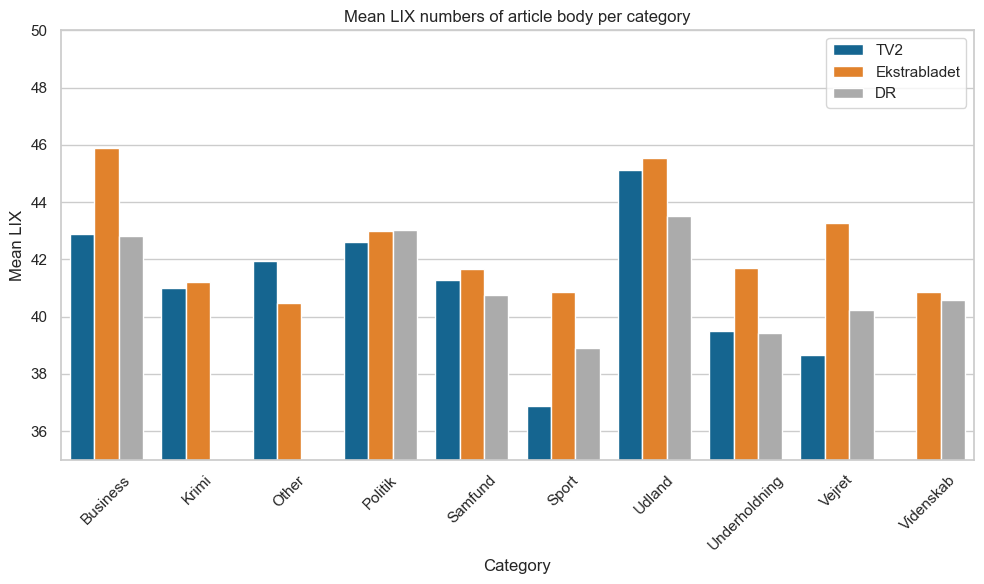

In [286]:
data = {
    'TV2': {
        'Business': 42.892673,
        'Krimi': 41.005867,
        'Other': 41.936740,
        'Politik': 42.599847,
        'Samfund': 41.264235,
        'Sport': 36.890642,
        'Udland': 45.113927,
        'Underholdning': 39.500152,
        'Vejret': 38.664221,
        'Videnskab': None
    },
    'Ekstrabladet': {
        'Business': 45.909874,
        'Krimi': 41.212991,
        'Other': 40.494700,
        'Politik': 42.984884,
        'Samfund': 41.663670,
        'Sport': 40.853632,
        'Udland': 45.534034,
        'Underholdning': 41.699398,
        'Vejret': 43.289686,
        'Videnskab': 40.859067
    },
    'DR': {
        'Business': 42.830510,
        'Krimi': None,
        'Other': None,
        'Politik': 43.035137,
        'Samfund': 40.745136,
        'Sport': 38.918328,
        'Udland': 43.527046,
        'Underholdning': 39.416492,
        'Vejret': 40.237805,
        'Videnskab': 40.578331
    }
}

# Create a DataFrame from the data
df = pd.DataFrame(data)

# Melt the DataFrame for plotting
melted_df = df.melt(value_name='LIX', var_name='Media', ignore_index=False)


# Plotting using Seaborn
plt.style.use('tableau-colorblind10')
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x=melted_df.index,
    y='LIX',
    hue='Media',
    data=melted_df,
    ci=None,
    #palette= colors  # Use the custom colors defined
)
plt.title('Mean LIX numbers of article body per category')
plt.xlabel('Category')
plt.ylabel('Mean LIX')
plt.xticks(rotation=45)
plt.legend(title='Media')
plt.tight_layout()
ax.set_ylim(35, 50)# Set ci=None to remove error bars
plt.legend(loc='upper right')

# Display the plot
plt.show()


In [209]:
df_ekstrabladet

,Unnamed: 0,link,title,body,num_of_words,author,time,category,time_group,first_name,Boy,Girl,Nyhedsbureau,LIX_body,LIX_Headline,Media
0,0,https://ekstrabladet.dk/krimi/bowlinghal-tilta...,Bowlinghal tiltalt for uagtsomt manddrab,I sommeren sidste år mistede en 29-årig mand l...,100,Signe Søgaard,2023-08-15 14:12:00,Krimi,day,Signe,0,1,0,42.386340,85.000000,Ekstrabladet
1,1,https://ekstrabladet.dk/krimi/snoevlende-mand-...,Snøvlende mand antastede og skubbede teenagepige,To teenagepiger fik sig mandag aften en forskr...,102,Emma Buus Mosegaard,2023-08-17 07:59:00,Krimi,morning,Emma,0,1,0,42.824324,72.666667,Ekstrabladet
2,2,https://ekstrabladet.dk/krimi/boederegn-181-bi...,Bøderegn: 181 bilister gået i fælden,"Skoleferien er ovre, og bilisterne er tilbage ...",102,Lasse Emil Stiigvad,2023-08-15 18:41:00,Krimi,evening,Lasse,1,0,0,36.724868,39.333333,Ekstrabladet
3,3,https://ekstrabladet.dk/krimi/uheld-skaber-koe...,Uheld giver kø på motorvej,"Pendlere fra Nordsjælland, der skal mod Københ...",105,Emma Buus Mosegaard,2023-08-16 07:10:00,Krimi,morning,Emma,0,1,0,35.756757,25.000000,Ekstrabladet
4,4,https://ekstrabladet.dk/krimi/efterlyser-39-aa...,Efterlyser 39-årig: Mistænkt for trusler,I juli skulle 39-årige Christian Peder Majlund...,106,Petra Akullu Møller,2023-08-15 08:35:00,Krimi,day,Petra,0,1,0,42.199234,56.000000,Ekstrabladet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1727,1727,https://ekstrabladet.dk/nyheder/samfund/famili...,Familie splittet: Mor til baby smidt ud,På første sal i en baggårdslejlighed i Helsing...,2366,Cecilie Guldberg,2023-03-08 12:14:00,Samfund,day,Cecilie,0,1,0,42.249066,35.571429,Ekstrabladet
1728,1728,https://ekstrabladet.dk/nationen/langer-ud-toe...,Langer ud: Tøsedrenge,- FN´s klimapanel (IPCC) publicerede i august ...,2398,Thomas Harder,2021-09-12 21:34:00,Sport,evening,Thomas,1,0,0,43.558901,36.333333,Ekstrabladet
1729,1729,https://ekstrabladet.dk/nyheder/samfund/smidt-...,Smidt ud efter regel-koks: Forsøgte at tage si...,"Klokken er kvart over to om natten, og thailan...",2399,Cecilie Guldberg,2023-03-02 07:52:00,Samfund,morning,Cecilie,0,1,0,40.512540,20.090909,Ekstrabladet
1730,1730,https://ekstrabladet.dk/nationen/helt-haabloes...,Helt håbløst: Projekt til 200 milliarder søger...,- Vi - Ib og Søren – skrev i Ekstra Bladets e-...,2692,Thomas Harder,2021-06-01 17:16:00,Sport,evening,Thomas,1,0,0,45.140999,45.500000,Ekstrabladet


In [216]:
merged_df = pd.concat([df_ekstrabladet, df_tv2, df_dr], axis=0).reset_index()
merged_df.groupby('category')['num_of_words', 'LIX']


In [241]:
merged_df.groupby(['Media'])['num_of_words', 'LIX', 'Boy', 'Girl', 'LIX_Headline'].mean()

,num_of_words,LIX,Boy,Girl,LIX_Headline
Media,,,,,
DR,680.632558,41.475287,0.674419,0.374419,43.273596
Ekstrabladet,443.744226,41.754745,0.605081,0.290416,36.892740
TV2,518.935006,40.862654,0.530715,0.239341,41.611229


In [230]:
merged_df['mean_LIX'] = merged_df.groupby(['category', 'Media'])['LIX'].transform('mean')

# Calculate the difference in LIX mean between different media within each category
merged_df['LIX_mean_difference'] = merged_df.groupby('category')['mean_LIX'].transform(lambda x: x - x.mean())


,index,Unnamed: 0,link,title,body,num_of_words,author,time,category,time_group,first_name,Boy,Girl,Nyhedsbureau,LIX,LIX_Headline,Media,Live,mean_LIX,LIX_mean_difference
0,0,0.0,https://ekstrabladet.dk/krimi/bowlinghal-tilta...,Bowlinghal tiltalt for uagtsomt manddrab,I sommeren sidste år mistede en 29-årig mand l...,100,Signe Søgaard,2023-08-15 14:12:00,Krimi,day,Signe,0,1,0,42.386340,85.000000,Ekstrabladet,NaN,41.212991,0.189343
1,1,1.0,https://ekstrabladet.dk/krimi/snoevlende-mand-...,Snøvlende mand antastede og skubbede teenagepige,To teenagepiger fik sig mandag aften en forskr...,102,Emma Buus Mosegaard,2023-08-17 07:59:00,Krimi,morning,Emma,0,1,0,42.824324,72.666667,Ekstrabladet,NaN,41.212991,0.189343
2,2,2.0,https://ekstrabladet.dk/krimi/boederegn-181-bi...,Bøderegn: 181 bilister gået i fælden,"Skoleferien er ovre, og bilisterne er tilbage ...",102,Lasse Emil Stiigvad,2023-08-15 18:41:00,Krimi,evening,Lasse,1,0,0,36.724868,39.333333,Ekstrabladet,NaN,41.212991,0.189343
3,3,3.0,https://ekstrabladet.dk/krimi/uheld-skaber-koe...,Uheld giver kø på motorvej,"Pendlere fra Nordsjælland, der skal mod Københ...",105,Emma Buus Mosegaard,2023-08-16 07:10:00,Krimi,morning,Emma,0,1,0,35.756757,25.000000,Ekstrabladet,NaN,41.212991,0.189343
4,4,4.0,https://ekstrabladet.dk/krimi/efterlyser-39-aa...,Efterlyser 39-årig: Mistænkt for trusler,I juli skulle 39-årige Christian Peder Majlund...,106,Petra Akullu Møller,2023-08-15 08:35:00,Krimi,day,Petra,0,1,0,42.199234,56.000000,Ekstrabladet,NaN,41.212991,0.189343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27698,425,NaN,https://www.dr.dk/sporten/fodbold/kvindelandsh...,"Der er ny chef på landstrænerkontoret, og 'kon...",Der sker noget nyt på gangene i DBUs hovedkvar...,831,Jonas Sauermilch,2023-08-17 22:00:00+00:00,Sport,evening,NaN,1,0,0,36.634647,43.769231,DR,NaN,38.918328,1.786760
27699,426,NaN,https://www.dr.dk/nyheder/indland/kunstig-inte...,Kunstig intelligens hjælper ordblinde Kasper t...,Kasper Hjortvig er god til at snakke og formul...,955,Kåre Kildall Rysgaard,2023-08-17 14:36:00+00:00,Samfund,day,NaN,1,0,0,38.817204,48.333333,DR,NaN,40.745136,-0.524020
27700,427,NaN,https://www.dr.dk/nyheder/udland/et-aar-siden-...,For et år siden blev Annas landsby befriet fra...,Med en sulten og lidt for varm fem måneder gam...,1145,Louise Brodthagen Jensen - Kharkiv,2023-08-18 06:00:00+00:00,Udland,morning,NaN,0,1,0,38.436948,51.909091,DR,NaN,43.527046,-1.571570
27701,428,NaN,https://www.dr.dk/nyheder/kultur/det-begyndte-...,Det begyndte med et nazistisk symbol. Så kom r...,Hvis du bevæger dig rundt i København i disse ...,1248,Silas Bay Nielsen,2023-08-17 13:49:00+00:00,Underholdning,day,NaN,1,0,0,43.258929,26.750000,DR,NaN,39.416492,-1.799986


In [276]:
merged_df.groupby(['category'])[['LIX', 'num_of_words']].mean()

,LIX,num_of_words
category,,
Business,42.998401,575.651289
Krimi,41.024038,456.605723
Other,41.868679,826.073099
Politik,42.641829,726.003554
Samfund,41.269247,559.610100
Sport,37.132129,384.766699
Udland,45.097874,591.254722
Underholdning,41.216478,460.183186
Vejret,38.687332,377.611261


In [294]:
df_lix_media = merged_df.groupby('Media')['LIX', 'num_of_words'].mean()
df_lix_media.reset_index(inplace=True)
df_lix_media

,Media,LIX,num_of_words
0,DR,41.475287,680.632558
1,Ekstrabladet,41.754745,443.744226
2,TV2,40.862654,518.935006


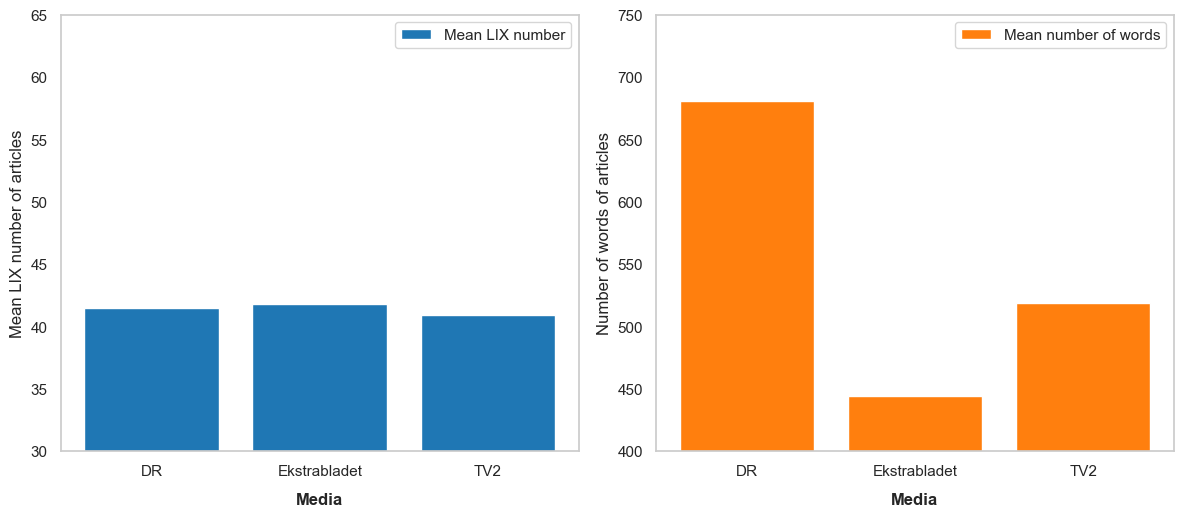

In [325]:
media_labels = df_lix_media['Media']

color_palette = ['#1f77b4', '#ff7f0e', '#2ca02c']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot side-by-side bar plots for LIX mean and num_of_words
ax1.bar(df_lix_media.index, df_lix_media['LIX'], color=color_palette[0], label='Mean LIX number')
ax1.set_ylabel('Mean LIX number of articles')
ax1.set_xlabel('Media', labelpad=10, weight='bold')
ax1.set_ylim(30, 65)  # Set y-axis limits for LIX Mean plot
ax1.grid(False) 

ax2.bar(df_lix_media.index, df_lix_media['num_of_words'], color=color_palette[1], label='Mean number of words')
ax2.set_ylabel('Number of words of articles')
ax2.set_xlabel('Media', labelpad=10, weight='bold')
ax2.set_ylim(400, 750)  # Set y-axis limits for num_of_words plot
ax2.grid(False) 

# Set x-axis tick labels
ax1.set_xticks(range(len(df_lix_media)))
ax1.set_xticklabels(["DR", "Ekstrabladet", "TV2"])

ax2.set_xticks(range(len(df_lix_media)))
ax2.set_xticklabels(["DR", "Ekstrabladet", "TV2"])

# Combine the legend entries
ax1.legend()
ax2.legend()

# Set overall plot title and layout
plt.suptitle('')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout for title

plt.show()